In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [ ]:
# -------------------------------
# STEP 1: Load and Clean Dataset
# -------------------------------
df = pd.read_csv("final_flood_classification data.csv")

# Replace '--' with NaN across the dataset
df = df.replace("--", np.nan)

In [ ]:
# -------------------------------
# STEP 2: Drop Unnecessary Columns
# -------------------------------
# These columns were identified as unnecessary for the model training.
df = df.drop(columns=["Areas", "Nearest Station", "Drainage_properties"])

In [ ]:
# -------------------------------
# STEP 3: Handle Categorical Variables Safely
# -------------------------------
# These columns are encoded to numeric values using LabelEncoder.
cat_cols = ["Ward Code", "Land Use Classes", "Flood_occured", "Road Density_m", "Monitoring_required", "Soil Type"]

for col in cat_cols:
    # Convert to string and fill NaN with "Unknown" before encoding
    df[col] = df[col].astype(str).fillna("Unknown")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

In [ ]:
# -------------------------------
# STEP 4: Handle Numeric Columns (Fill Missing)
# -------------------------------
# Missing numerical values are filled with the median to avoid errors.
for col in df.select_dtypes(include=['float64', 'int64']).columns:
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(df[col].median())


In [ ]:
# -------------------------------
# STEP 5: Feature/Target Separation and Encoding
# -------------------------------
# 'Flood-risk_level' is the target variable (y) for your model.
# All other relevant columns are the features (X).
X = df.drop(columns=["Flood-risk_level", "DATE"])
y = df["Flood-risk_level"]

# Encode the target variable `y` into numerical values
target_encoder = LabelEncoder()
y = target_encoder.fit_transform(y)

In [ ]:
# -------------------------------
# STEP 6: Train-Test Split
# -------------------------------
# The data is split into training and testing sets to evaluate the model's performance on unseen data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# -------------------------------
# STEP 7: Scale Numeric Columns
# -------------------------------
# Numeric features are scaled to a standard range, which helps improve model performance.
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
scaler = StandardScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

print("✅ Preprocessing complete")
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

✅ Preprocessing complete
Training set shape: (5688, 22)
Test set shape: (1422, 22)


In [ ]:
# -------------------------------
# STEP 8: Model Design and Training
# -------------------------------
# Define and train the individual models.
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6, subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric="mlogloss")
ensemble_model = VotingClassifier(estimators=[("rf", rf_model), ("xgb", xgb_model)], voting="soft")

print("\nTraining Random Forest...")
rf_model.fit(X_train, y_train)

print("Training XGBoost...")
xgb_model.fit(X_train, y_train)

print("Training Ensemble Model...")
ensemble_model.fit(X_train, y_train)


Training Random Forest...
Training XGBoost...
Training Ensemble Model...


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='mlogloss',
                                            feature_types=None,
                                            feature...None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=200, n_jobs=None,
                                            num_parallel_tree=None, ...))],
                 voting='soft')


✅ Random Forest Accuracy: 0.9986
Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00      1120
    Moderate       0.99      1.00      1.00       302

    accuracy                           1.00      1422
   macro avg       1.00      1.00      1.00      1422
weighted avg       1.00      1.00      1.00      1422



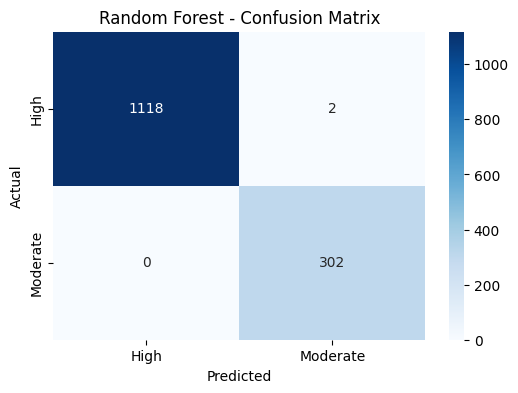


✅ XGBoost Accuracy: 0.9993
Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00      1120
    Moderate       1.00      1.00      1.00       302

    accuracy                           1.00      1422
   macro avg       1.00      1.00      1.00      1422
weighted avg       1.00      1.00      1.00      1422



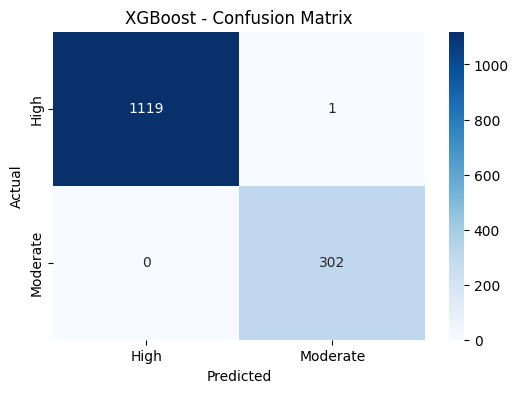


✅ Ensemble (RF+XGB) Accuracy: 0.9993
Classification Report:
               precision    recall  f1-score   support

        High       1.00      1.00      1.00      1120
    Moderate       1.00      1.00      1.00       302

    accuracy                           1.00      1422
   macro avg       1.00      1.00      1.00      1422
weighted avg       1.00      1.00      1.00      1422



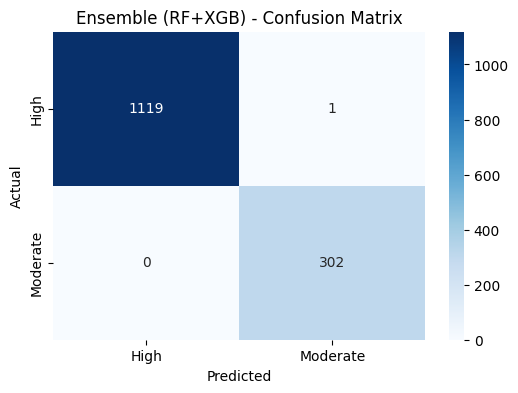

In [ ]:
# -------------------------------
# STEP 9: Evaluate Models
# -------------------------------
# Evaluate the performance of each model on the test set.
models = {
    "Random Forest": rf_model,
    "XGBoost": xgb_model,
    "Ensemble (RF+XGB)": ensemble_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n✅ {name} Accuracy: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0, target_names=target_encoder.classes_))

    # Generate and plot confusion matrix.
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_encoder.classes_, yticklabels=target_encoder.classes_)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


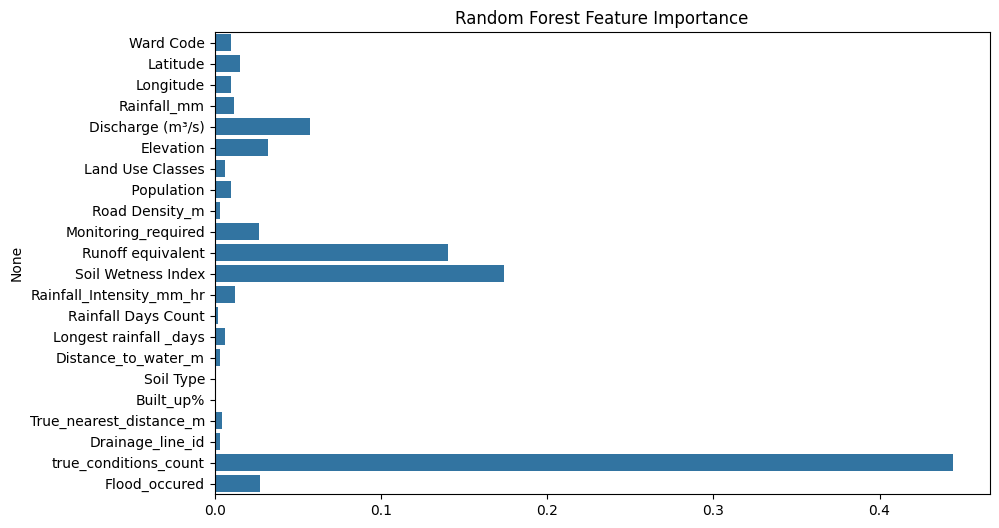

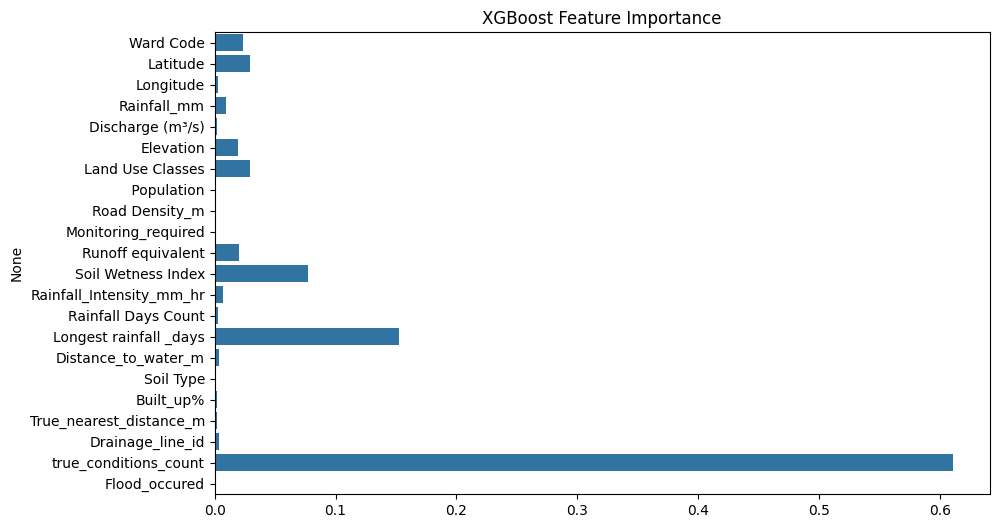

In [ ]:
# -------------------------------
# STEP 10: Feature Importance
# -------------------------------
# Plotting feature importance to understand which features contribute most to the predictions.
importances_rf = rf_model.feature_importances_
importances_xgb = xgb_model.feature_importances_
features = X_train.columns

plt.figure(figsize=(10,6))
sns.barplot(x=importances_rf, y=features)
plt.title("Random Forest Feature Importance")
plt.show()

plt.figure(figsize=(10,6))
sns.barplot(x=importances_xgb, y=features)
plt.title("XGBoost Feature Importance")
plt.show()


In [ ]:
import joblib

# Save the trained ensemble model
joblib.dump(ensemble_model, 'ensemble_model.joblib')

# Save the scaler
joblib.dump(scaler, 'scaler.joblib')

# Save the target encoder
joblib.dump(target_encoder, 'target_encoder.joblib')

print("\n✅ Models and encoders saved successfully.")


✅ Models and encoders saved successfully.


In [ ]:
pip install Flask